#### Montando entorno

In [62]:
import pandas as pd
# Importacion de Plotly como libreria de DataViz
import plotly.express as px
import json

In [63]:
import os

# Obtiene la ubicación completa del archivo del notebook
notebook_path = os.path.realpath('__file__')

# Obtiene la ruta absoluta de la carpeta "Coderhouser-DS-TP0002" sin importar donde te encuentres
path_base = os.path.abspath(os.path.join(notebook_path, "..", "..", "..", "..", "Coderhouser-DS-TP0002"))

print("Path base:", path_base)
print("Directorio actual:", os.getcwd())

Path base: C:\develoment\Coderhouser-DS-TP0002
Directorio actual: c:\develoment\Coderhouser-DS-TP0002\models\Decision_Forest


In [64]:
import sys
sys.path.append(path_base + r"\models")

In [65]:
# Importacion de sklearn para el modelo Decision Tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, classification_report, ConfusionMatrixDisplay, confusion_matrix
import joblib

In [66]:
def model_train_test(model, xts, xTest, yTrain, yTest):
    model.fit(xts, yTrain)
    y_predict = model.predict(xTest)
    print(classification_report(yTest, y_predict))
    ConfusionMatrixDisplay.from_estimator(model, xTest, yTest)

#### Leyendo datos:

In [67]:
# Generando el Dataframe del dataset base
df = pd.read_csv( path_base + r"\\data\procesed\blueTeam.csv")
test_data = pd.read_csv( path_base + r"\\data\procesed\redTeam.csv")

#### Definiendo Características 

In [68]:
with open(path_base + r"\\models\features.json", 'r') as archivo:
    featuresDicc = json.load(archivo)

In [69]:
for feature in featuresDicc["grupos"]:
    print(feature['nombre'])

Conjunto de Características de Visión
Conjunto de Características de Rendimiento en Combate
Conjunto de Características de Desarrollo y Experiencia
Conjunto de Características de Combate Temprano
Conjunto de Características Económicas
Conjunto de Características de Desempeño en Dragones y Heralds


In [70]:
df_pred = df[featuresDicc["grupos"][5]['variables']+["Wins"]]

### Construyendo el modelo Decision Tree

### Separación de Datos:
- se dividio en un 80% de los datos para entrenamiento y un 20% para prueba.

In [71]:
X = df_pred.drop("Wins", axis = 1)
y = df["Wins"]

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)

#### Estandarización de Características:

In [73]:
scaling = StandardScaler()
X_train_scaled = scaling.fit_transform(X_train)
X_test_scaled = scaling.transform(X_test)

### Entrenamiento de un Modelo de Machine Learning:
- Se carga la libreria **sklearn** con el modelo **RandomForestClassifier** y se procede a realizar su entrenamiento

In [74]:
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)


DecisionTreeClassifier(random_state=42)

### Evaluación del Modelo:
- Se evalúa el modelo con el conjunto de prueba utilizando métricas apropiadas.

              precision    recall  f1-score   support

           0       0.66      0.66      0.66       990
           1       0.66      0.65      0.65       986

    accuracy                           0.66      1976
   macro avg       0.66      0.66      0.66      1976
weighted avg       0.66      0.66      0.66      1976



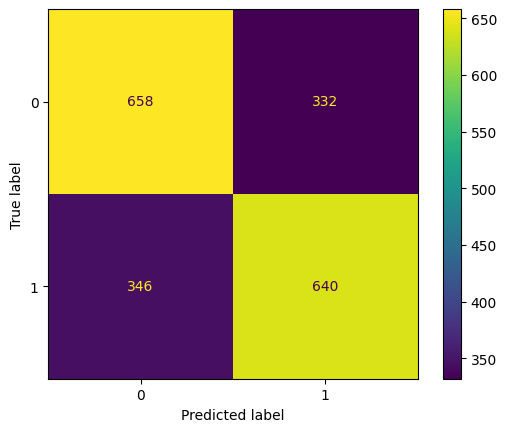

In [75]:
y_pred = model.predict(X_test)
model_train_test(model, X_train_scaled, X_test_scaled, y_train, y_test)


### Ajuste y Optimización del Modelo:

##### Ajuste de Hiperparámetros:
 - proceso de reentrenamiento para una mejor afinacion de resultado

In [76]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

              precision    recall  f1-score   support

           0       0.70      0.73      0.72       990
           1       0.72      0.69      0.70       986

    accuracy                           0.71      1976
   macro avg       0.71      0.71      0.71      1976
weighted avg       0.71      0.71      0.71      1976



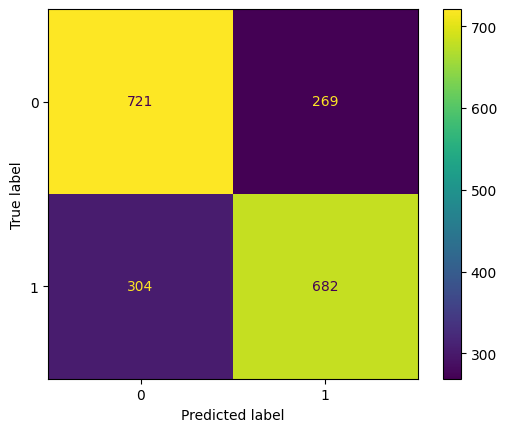

In [77]:
model_train_test(best_model, X_train_scaled, X_test_scaled, y_train, y_test)


##### Validación Cruzada:

Realiza la validación cruzada para obtener una evaluación más robusta del rendimiento de tu modelo en diferentes conjuntos de datos.

In [78]:
from sklearn.model_selection import cross_val_score
import numpy as np

cv_scores = cross_val_score(best_model, X_train, y_train, cv=5)
average_cv_accuracy = np.mean(cv_scores)


##### Curva de Aprendizaje:

Plotea la curva de aprendizaje para entender si tu modelo se beneficiaría de más datos de entrenamiento o si está sobreajustado.

In [79]:
import plotly.graph_objects as go
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y, cv=5):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv)

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=train_sizes,
        y=train_scores_mean,
        mode='lines',
        name='Training Score',
        line=dict(color='blue')
    ))

    fig.add_trace(go.Scatter(
        x=train_sizes,
        y=test_scores_mean,
        mode='lines',
        name='Cross-validation Score',
        line=dict(color='orange')
    ))

    fig.update_layout(
        title='Curva de Aprendizaje',
        xaxis_title='Tamaño del Conjunto de Entrenamiento',
        yaxis_title='Puntuación de Exactitud',
        legend=dict(x=0.02, y=0.95),
        margin=dict(l=0, r=0, t=30, b=0)
    )

    fig.show()
    fig.write_html(path_base + r"\\static\html\df_prediccion.html")
    fig.write_image(path_base + r"\\static\img\df_prediccion.png")

# Utiliza la función con tu mejor modelo y conjuntos de entrenamiento
plot_learning_curve(best_model, X_train, y_train)

##### Ensemble Methods:

Puedes probar métodos de conjunto (ensemble methods) como Bagging, Boosting, o Stacking para mejorar el rendimiento del modelo.

In [80]:
from sklearn.ensemble import BaggingClassifier

bagging_model = BaggingClassifier(base_estimator=best_model, n_estimators=10, random_state=42)
bagging_model.fit(X_train, y_train)

c:\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning:

`base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.



BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=10,
                                                        random_state=42),
                  random_state=42)

### Creandoo un Bucle de modelos segun los grupo de Feature marcados

In [81]:
# Crear un DataFrame con los totales
totals = pd.DataFrame({"Categoría": ["Real"], "Total": [test_data["Wins"].sum()]})

In [82]:
def train_decision_tree_model(features_list, df):
    X = df[features_list['variables']]
    y = df["Wins"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    param_grid = {
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5)
    grid_search.fit(X_train_scaled, y_train)

    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_
    score = best_model.score(X_test_scaled, y_test)

    return best_model, best_params, score

In [83]:
fig = go.Figure()
set_number = 1
modelos = {}

for featureList in featuresDicc["grupos"]:
    model, best_params, tree_score = train_decision_tree_model(featureList, df)
    modelos["set_" + str(set_number)] = model

    name = "Modelo " + str(set_number)
    test = test_data[featureList['variables']]
    predictions = model.predict(test)
    test_data[name] = predictions
    
    totals.loc[set_number] = [name, test_data[name].sum()]
    featuresDicc["grupos"][set_number-1]["DecisionTree"] = tree_score

    # Guardar el modelo
    joblib.dump(model, f'DecisionTree_{name}.pkl')

    set_number += 1


c:\Python311\Lib\site-packages\sklearn\base.py:457: UserWarning:

X has feature names, but DecisionTreeClassifier was fitted without feature names

c:\Python311\Lib\site-packages\sklearn\base.py:457: UserWarning:

X has feature names, but DecisionTreeClassifier was fitted without feature names

c:\Python311\Lib\site-packages\sklearn\base.py:457: UserWarning:

X has feature names, but DecisionTreeClassifier was fitted without feature names

c:\Python311\Lib\site-packages\sklearn\base.py:457: UserWarning:

X has feature names, but DecisionTreeClassifier was fitted without feature names

c:\Python311\Lib\site-packages\sklearn\base.py:457: UserWarning:

X has feature names, but DecisionTreeClassifier was fitted without feature names

c:\Python311\Lib\site-packages\sklearn\base.py:457: UserWarning:

X has feature names, but DecisionTreeClassifier was fitted without feature names



In [84]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(models, X, y, cv=5):
    fig = go.Figure()

    for model_name, model in models.items():
        train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=cv)
        train_scores_mean = np.mean(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)

        fig.add_trace(go.Scatter(
            x=train_sizes,
            y=train_scores_mean,
            mode='lines',
            name=f'Training Score ({model_name})',
        ))

        fig.add_trace(go.Scatter(
            x=train_sizes,
            y=test_scores_mean,
            mode='lines',
            name=f'Cross-validation Score ({model_name})',
        ))

    fig.update_layout(
        title='Curva de Aprendizaje',
        xaxis_title='Tamaño del Conjunto de Entrenamiento',
        yaxis_title='Puntuación de Exactitud',
        legend=dict(x=0.02, y=0.95),
        margin=dict(l=0, r=0, t=30, b=0)
    )

    fig.show()
    fig.write_html(path_base + r"\\static\html\df_learning_curve.html")
    fig.write_image(path_base + r"\\static\img\df_learning_curve.png")

plot_learning_curve(modelos, X_train, y_train)


### Aplicando modelo con Red
El siguiente informe presenta la evaluación del modelo Decision Tree aplicado a los datos del equipo Red. El objetivo de este análisis es determinar la capacidad del modelo entrenado en los datos del equipo Blue para generalizar y realizar predicciones precisas en el contexto de los datos del equipo Red.

In [85]:
# Calcular la diferencia entre cada modelo y el valor "Real"
totals['Diferencia_Real'] = totals['Total'] - totals.loc[totals['Categoría'] == 'Real', 'Total'].values[0]

In [86]:
# Crear un gráfico de barras
fig_comparison = px.bar(totals, x="Categoría", y="Total", text="Total", color='Diferencia_Real', color_continuous_scale=['red', 'green', 'red'],
                        title="Comparación del Total de partidas Reales (Wins) vs Modelos de Features",
                        labels={"Categoría": "Categoría", "Total": "Total"})

# Mostrar el gráfico
fig_comparison.update_traces(texttemplate='%{text}', textposition='outside')
fig_comparison.show()
fig_comparison.write_html(path_base + r"\\static\html\df_models_comparations.html")
fig_comparison.write_image(path_base + r"\\static\img\df_models_comparations.png")

### Control de Modelos con la Matriz de confusión

In [87]:
resultados = test_data[["Wins","Modelo 1","Modelo 2","Modelo 3","Modelo 4","Modelo 5","Modelo 6"]]

In [88]:
columnas_modelos = ["Modelo 1", "Modelo 2", "Modelo 3", "Modelo 4", "Modelo 5", "Modelo 6"]

# Crear un diccionario para almacenar las tablas de resultados
tablas_resultados = {}

# Crear y agregar cada tabla de resultados al diccionario
for modelo in columnas_modelos:
    matriz = confusion_matrix(resultados["Wins"], resultados[modelo])
    df_matriz = pd.DataFrame(matriz, index=["Wins 0", "Wins 1"], columns=["Predicho 0", "Predicho 1"])
    
    # Calcular FN, FP, TN, TP
    FN = df_matriz.loc["Wins 1", "Predicho 0"]
    FP = df_matriz.loc["Wins 0", "Predicho 1"]
    TN = df_matriz.loc["Wins 0", "Predicho 0"]
    TP = df_matriz.loc["Wins 1", "Predicho 1"]

    # Crear la tabla de resultados y agregar al diccionario
    tabla_resultados = pd.DataFrame({"Modelo": [modelo], "FN": [FN], "FP": [FP], "TN": [TN], "TP": [TP]})
    tablas_resultados[modelo] = tabla_resultados

# Concatenar las tablas en un solo DataFrame
df_resultados_completo = pd.concat(tablas_resultados.values(), ignore_index=True)

In [89]:
df_resultados_completo

,Modelo,FN,FP,TN,TP
0,Modelo 1,4551,194,4736,398
1,Modelo 2,1381,1367,3563,3568
2,Modelo 3,3268,2318,2612,1681
3,Modelo 4,215,4208,722,4734
4,Modelo 5,3,4929,1,4946
5,Modelo 6,1234,1480,3450,3715


In [90]:
radarData = df_resultados_completo.melt(id_vars="Modelo")

In [91]:

fig = px.line_polar(radarData, r='value', theta="variable",
                    line_close=True, title="Superposicion de Matrices de confusión",
                    color="Modelo")
fig.update_traces(fill='toself')
fig.write_html(path_base + r"\\static\html\df_Matrices_confusión.html")
fig.write_image(path_base + r"\\static\img\df_Matrices_confusión.png")
fig.show()

### Control de Modelos con la Curva ROC

In [92]:
# Función para plotear la curva ROC en Plotly
def plot_roc_curve_plotly(models):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], 
                            mode='lines', 
                            line=dict(color='navy', width=2, dash='dash'),
                            name='Random'))
    for model_name, model in models.items():  
        setFeature = featuresDicc["grupos"][int(model_name.split("_")[1])-1]      
        X = df[setFeature['variables']]
        y = df["Wins"]
        y_probs = model.predict_proba(X)[:, 1]
        fpr, tpr, _ = roc_curve(y, y_probs)
        roc_auc = auc(fpr, tpr)

        fig.add_trace(go.Scatter(x=fpr, y=tpr, 
                                mode='lines', 
                                line=dict(color=setFeature["color"], width=2),
                                name=f'{model_name} (AUC = {roc_auc:.2f})'))
        print(model_name,roc_auc)

    fig.update_layout(
        title=f'Curva ROC de todos los modelos',
        xaxis_title='False Positive Rate',
        yaxis_title='True Positive Rate',
        legend=dict(x=0.78, y=0.02),
        margin=dict(l=0, r=0, t=30, b=0)
    )

    fig.show()
    fig.write_html(path_base + r"\\static\html\df_curve_roc.html")
    fig.write_image(path_base + r"\\static\img\df_curve_roc.png")

In [93]:
plot_roc_curve_plotly(modelos)

set_1 0.4550632885451894
set_2 0.7093137425676996
set_3 0.41792705474132297
set_4 0.5519714884929731
set_5 0.5002016921483514
set_6 0.7248833845590131


c:\Python311\Lib\site-packages\sklearn\base.py:457: UserWarning:

X has feature names, but DecisionTreeClassifier was fitted without feature names

c:\Python311\Lib\site-packages\sklearn\base.py:457: UserWarning:

X has feature names, but DecisionTreeClassifier was fitted without feature names

c:\Python311\Lib\site-packages\sklearn\base.py:457: UserWarning:

X has feature names, but DecisionTreeClassifier was fitted without feature names

c:\Python311\Lib\site-packages\sklearn\base.py:457: UserWarning:

X has feature names, but DecisionTreeClassifier was fitted without feature names

c:\Python311\Lib\site-packages\sklearn\base.py:457: UserWarning:

X has feature names, but DecisionTreeClassifier was fitted without feature names

c:\Python311\Lib\site-packages\sklearn\base.py:457: UserWarning:

X has feature names, but DecisionTreeClassifier was fitted without feature names



## Guardado de los resultados sobre el catálogo de Features

In [94]:
with open(path_base + r"\\models\features.json", 'w') as archivo:
    json.dump(featuresDicc, archivo)